In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### Blocking Image

In [2]:
def readImage(img):
    """
    This function divides the 512x512 image into 1024 blocks, each of which 
    are 16x16 in size. Once the image is seperated into blocks, each block 
    is converted into vectors of length 256. 
    Inputs: img - numpy array of image pixels 
    Outputs: X - numpy array of size 256x1024 
    """
    
    #preallocate size for X
    X = np.zeros([256, 1024])
    
    #initialize k 
    k = 0
    
    #step size 
    step = 16

    #loop through pixels of image 
    for i in range(0, 512, step):
        for j in range(0, 512, step):
            #split into 1024 blocks of 16x16
            block = img[i:i+step, j:j+step]
            #reshape each block into a vector of length 256
            X[:,k] = np.reshape(block, (1, 256))#total of 1024 vectors
            #sum up k
            k +=1
            
    #return 1024 vectors of length 256
    return X

### K-Means Algorithm

In [3]:
import scipy.spatial.distance as dist 

#function to calculate the closest centroids 
def closestCentroids(img, centroids):
    
    #initialize empty list to hold minimum generators 
    generator = np.zeros([256, 20])
    
    assignment = []
        
    #iterate through length of the original image 
    for i in range(img.shape[1]):
        
        #variable iterates and stores each row of image matrix 
        vals = img[:,i]
        
        #using list comprehension to calculate the euclidean distance from image and each centroid 
        euclid = [abs(vals[0] - centroids[0][j]) + abs(vals[1] - centroids[1][j]) for j in range(np.array(centroids).shape[1])]
        
        #add min euclidian distance 
        generator[:,np.argmin(euclid)] = vals
        
        assignment.append(np.argmin(euclid))
    
    #return min generators 
    return generator, assignment

In [4]:
#function to update generators for each iteration of k means 
def updateGenerators(image_blocks, nclusters, cluster_assignments):
    
    #empty array to hold new generators 
    new_generators = np.zeros([256, 20])
    
    #loop through the length of number of clusters 
    for i in range(nclusters):
        
        indexes = np.where(np.array(cluster_assignments) == i)[0]
        
        averages = np.average(image_blocks[:,indexes], axis=1)
        
        #append the average generator for each dimension 
        #return a vector with 3 vals 
        new_generators[:, i] = averages
        
    #return new generators 
    return new_generators

In [5]:
#import external modules 
import random

#function to perform k means clustering 
def kmeans(img, nclusters):
    
    #create initial generators from original image matrix 
    generator = img[:,0:20]
    
    #define iterations 
    iterations = 10
    
    mval = 100000
    tol = 1e-6
    
    #run k means for 10 iterations 
    while mval >= tol:
        
        #calculate closest generators  
        generator, assignment = closestCentroids(img, generator)
        
        #update new generators 
        new_generator = updateGenerators(img, nclusters, assignment)
        
        mval = np.linalg.norm(abs(new_generator - generator)/(new_generator + 1e-16))
        
        generator = new_generator
        
    return np.array(generator), assignment

In [6]:
def reconstructImage(generator, assignment):

    #preallocate size for X
    approx_image = np.zeros([512, 512])

    #initialize k 
    k = 0

    m,n = generator.shape

    #step size 
    step = 16

    #loop through pixels of image 
    for i in range(0, 512, step):
        for j in range(0, 512, step):
            #split into 1024 blocks of 16x16
            block = generator[:,assignment[k]]
            #reshape each block into a vector of length 256
            approx_image[i:i+step, j:j+step] = np.reshape(block, (16, 16))#total of 1024 vectors
            #sum up k
            k +=1
            
    return approx_image

In [156]:
def plotApproxImage(approximation, title):
    
    #generalized plots to show approximate image
    plt.imshow(approximation, cmap='gray')
    plt.title(title)

In [159]:
def runKmeans(image):
    
    #block original image
    image = readImage(image)
    
    #kmeans with 20 clusters on the block image 
    nclusters = 20
    generator, assignment = kmeans(image, nclusters)
    approximate_image = reconstructImage(generator, assignment)
    
    return approximate_image

In [162]:
#read in original image 
img = np.array(Image.open('TrumanEatsLunch.jpg'))

#run kmeans
approximate_image = runKmeans(img)

### First K-Means Run on Original Image

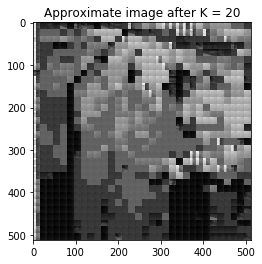

In [163]:
#create figure showing the approximated image after applying 
#k-means when k = 20 first run
plotApproxImage(approximate_image, 'Approximate image after K = 20')

### Difference Image

In [153]:
#figure out how different approximate image from the original image 
#take pixel by pixel subtraction 
def differencing(orignal_image, approximate_image):
    return abs(orignal_image - approximate_image)

In [164]:
#figure out how different reconstructed image is from original image
#call differencing function to take a pixel by pixel subtraction
difference = differencing(img, approximate_image)

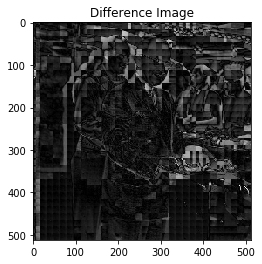

In [165]:
#create plot out of this difference 
plotApproxImage(difference, 'Difference Image')

### Second K-Means Run on Difference Image

In [166]:
#run K-Means on the difference image
reconstructed_image = runKmeans(difference)

C:\Users\cspoe\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\cspoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


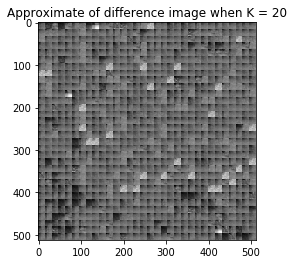

In [168]:
#reconstruct an approximate difference image out of the 
#centers of the second k means run by replacing each block in the image 
#with the center it was assigned to 
plotApproxImage(reconstructed_image, 'Approximate of difference image when K = 20')

### Final Reconstruction Improvements

In [13]:
#add the reconstructed_image and the reconstructed difference image together 
better_image = difference + reconstructed_image

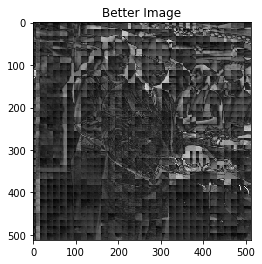

In [169]:
#plot better image 
plotApproxImage(better_image, 'Better Image')

### Watermarking Preparation

In [15]:
#load in watermarking image 
smiley = np.array(Image.open('smiley.jpg'))

In [144]:
#binarize watermarking image
threshold, upper, lower = 0.5, 1, 0
W = np.where(smiley>threshold, upper, lower)

In [17]:
#read in original image
truman = np.array(Image.open('TrumanEatsLunch.jpg'))
#block image
img = readImage(truman)
#run k-Means a third time on the original image
nclusters = 20
generator, assignment = kmeans(img, nclusters)

### The Index Matrix

In [172]:
def indexesMatrix(assignment):
    
    #construct an "indexes matrix" representation of the image by 
    #reshaping the assignments array into a matrix size of 32x32
    return np.array(assignment).reshape(32, 32)

In [173]:
indexes = indexesMatrix(assignment)

### The Variance Matrix

In [176]:
def varianceMatrix(indexes):
    

    variance = np.zeros_like((indexes))

    #construct the variance matrix
    N = len(indexes)
    for i in range(2, N-1):
        for j in range(2, N-1):

            variance[i,j] = np.var((indexes[i,j], indexes[i-1,j], indexes[i+1,j], indexes[i,j-1], indexes[i,j+1], indexes[i-1,j-1], indexes[i-1,j+1], indexes[i+1,j+1]))
            variance[0,j] = np.var((indexes[0,j], indexes[0,j-1], indexes[1,j], indexes[1,j-1], indexes[1,j+1], indexes[0,j+1]))
            variance[-1,j] = np.var((indexes[-1,j], indexes[-1,j-1], indexes[-1,j+1], indexes[-2,j], indexes[-2,j+1], indexes[-2,j-1]))
            variance[i,0] = np.var((indexes[i,0], indexes[i+1,0], indexes[i-1,0], indexes[i-1,1], indexes[i,1], indexes[i+1,1]))
            variance[i,-1] = np.var((indexes[i,-1], indexes[i+1,-1], indexes[i-1,-1],indexes[i-1,-2], indexes[i,-2], indexes[i+1,-2]))
            variance[0,0] = np.var((indexes[0,0], indexes[0,1], indexes[1,0], indexes[1,1]))
            variance[-1,-1] = np.var((indexes[-1,-2], indexes[-2,-2], indexes[-2,-1], indexes[-1,-1]))
            variance[-1, 0] = np.var((indexes[-1,0], indexes[-2,0], indexes[-1,1], indexes[-2,2]))
    
    #pick a threshold. This is set to the global median of the variance 
    T = np.median(np.median(variance))
    
    return variance, T

In [177]:
variance, T = varianceMatrix(indexes)

### The Polarities Matrix

In [179]:
def polarityMatrix(variance, T):
    #using threshold T construct polarities matrix of size 32x32
    #each element is either a 0 or 1
    polarities = np.zeros_like((variance))

    m,n = variance.shape

    for i in range(m):
        for j in range(n):
            polarities[i,j] = 0 if variance[i,j] <= T else 1
    
    return polarities

In [180]:
polarities = polarityMatrix(variance, T)

### Watermark Permutation

In [142]:
#randomly permute the watermark image
key1 = np.zeros_like((variance))
for i in range(m):
    for j in range(n):
        key1[i,j] =  

SyntaxError: unexpected EOF while parsing (<ipython-input-142-149d7355af04>, line 2)

### Embedding the Watermark

In [135]:
#Embedding the watermark into the polarities matrix by the XOR operation
key2 = np.zeros_like(polarities)

for i in range(m):
    for j in range(n):
        key2[i,j] = np.bitwise_xor(polarities[i,j], Wp[i,j])

array([[[1, 0, 0, ..., 0, 0, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0]]])

### Image Approximation

In [171]:
#Image approximation 
#run K-Means once again on the original image when k=20
#read in original image 
img = np.array(Image.open('TrumanEatsLunch.jpg'))
image = readImage(img)

#kmeans with 20 clusters on the block image 
nclusters = 20
generator, assignment = kmeans(image, nclusters)
approximate_image = reconstructImage(generator, assignment)

C:\Users\cspoe\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\cspoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [183]:
#Re-compute the variance and polarities matrices from this 
indexes = indexesMatrix(assignment)
variance, T = varianceMatrix(indexes)
polarities_approx = polarityMatrix(variance, T)

### Extract the Watermark

In [ ]:
#extract the watermark from the approximate polarities matrix using the inverse operation
for i in range(m):
    for j in range(n):
        Wp[i,j] = np.bitwise_xor(key2[i,j], polarities_approx[i,j])
        
for k in range(m):
    W[k,:] = Wp[i,key1]